# Warning
This notebook is under development

# Experiments on cutting data with lag or lead

This is intended to allow researchers to deal with respiratory EMG data and ventilator data which may not be exactly synchronized, but has a consistent lag-time between the two signals.

## Import libraries

In [2]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate as interp
# IMPORT Ole's fixed TMSiSDK python interfacwe- may change
sys.path.insert(0,'C:/Projects/tmsi-python-interface')
from TMSiSDK.file_readers import Poly5Reader
import collections
import math
sys.path.insert(0, '../resurfemg')
import helper_functions as hf

C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


# Set a collection place for experiments

In [3]:
# do not rerun this cell
big_data_list= []

Below change the path to the root directory where you are keeping your EMGs and ventilator "Draeger" files

# Reruns should be done from this cell as the start

In [4]:
root_emg_directory = os.path.join('../not_pushed','topspin_data_anonymized')

In [5]:
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_draeger_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
draeger_files = []

for file in emg_and_draeger_files:
    if 'Draeger' in file:
        draeger_files.append(file)
    else:
        emg_files.append(file)

Now you can pick a file from the list, which have been numbered.

In [6]:
list_of_numbers_strung = []
for i in range(len(emg_files)):
    list_of_numbers_strung.append(str(i))


btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value='0',
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '1…

In [7]:
number_chosen = int(btn.value)
emg_file_chosen = emg_files[number_chosen]
draeger_file_chosen = draeger_files[number_chosen]
print("The files you chose are:\n", emg_file_chosen, '\n', draeger_file_chosen)

The files you chose are:
 ../not_pushed\topspin_data_anonymized\M002\005\EMG_recording.Poly5 
 ../not_pushed\topspin_data_anonymized\M002\005\Draeger_recording.Poly5


In [8]:
# get the poly5 reading
data_emg = Poly5Reader(emg_file_chosen)
data_draeger = Poly5Reader(draeger_file_chosen)
data_emg_samples = data_emg.samples
emg_sample_rate = data_emg.sample_rate
data_draeger_samples = data_draeger.samples
draeger_sample_rate = data_draeger.sample_rate

Reading file  ../not_pushed\topspin_data_anonymized\M002\005\EMG_recording.Poly5
	 Number of samples:  925792 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  ../not_pushed\topspin_data_anonymized\M002\005\Draeger_recording.Poly5
	 Number of samples:  45190 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


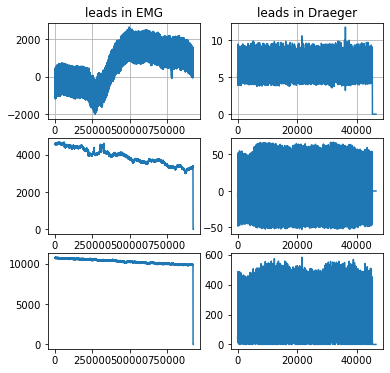

In [9]:
%matplotlib inline
# set up plot, show
x_emg = data_emg_samples
x_draeger = data_draeger_samples
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(6, 6))
axis[0, 0].grid(True)
axis[0, 0].plot(x_emg[0])
axis[0, 0].set(title='leads in EMG')
axis[1, 0].plot(x_emg[1])
axis[2, 0].plot(x_emg[2])
axis[0, 1].set(title='leads in Draeger')
axis[0, 1].grid(True)
axis[0, 1].plot(x_draeger[0])
axis[1, 1].plot(x_draeger[1])
axis[2, 1].plot(x_draeger[2])

That is the whole unfiltered EMG, but you probably want to examine a part. You will also want to examine something filtered down to only the EMG components. Therefore we can later filter off only the EMG components with an ICA in addtion to the filters we will play with.

## Automatic matching, when you know the lag/lead

Now you can input the time difference between the two samples.

In [10]:
dropdown = widgets.Dropdown(
    options=["leads", "lags"],
    value='lags',
    description="The EMG",
    disabled=False,
)

time_difference = widgets.Combobox(
    placeholder='type in number of milliseconds ',
    options=['', ],
    description='time difference'
)


# a VBox container to pack widgets vertically
widgets.VBox(
    [
        dropdown,
        time_difference,
    ]
)

Warning: you must put in a number value for the time difference even if it is zero. 

In [36]:
# now we need to downsample to emg data, we will start with a psuedotimestamp
draeger_frequency = 100
emg_frequency = 2048

dfourth_list_ids = list(range(len(data_draeger_samples[2])))
dfourth_list_ids = np.array(dfourth_list_ids)
dfourth_list_ids = dfourth_list_ids/draeger_frequency

efourth_list_ids = list(range(len(data_emg_samples[2])))
efourth_list_ids = np.array(efourth_list_ids)
efourth_list_ids = efourth_list_ids/emg_frequency

In [37]:
tsemg= np.vstack((data_emg_samples,efourth_list_ids))
tsdraeger = np.vstack((data_draeger_samples,dfourth_list_ids))

In [38]:
normalizer = len(tsdraeger[2])
resampled_emg_0 = scipy.signal.resample(data_emg_samples[0], normalizer)
resampled_emg_1 = scipy.signal.resample(data_emg_samples[1], normalizer)
resampled_emg_2 = scipy.signal.resample(data_emg_samples[2], normalizer)
ts_resampled = scipy.signal.resample(efourth_list_ids, normalizer)

resampled_emg_top = np.vstack((resampled_emg_0, resampled_emg_1))
resampled_emg = np.vstack((resampled_emg_top, resampled_emg_2))
tsresampled_emg = np.vstack((ts_resampled, resampled_emg))

In [39]:
sample_difference = int((int(time_difference.value)/1000) * draeger_frequency)
padding = []
for i in range(sample_difference):
    padding.append('NaN')
out = np.vstack((np.array(padding), np.array(padding)))
out_three = np.vstack((out, np.array(padding)))
out_four = np.vstack((out_three, np.array(padding)))

In [40]:
#sample_difference

0

In [28]:
# must replace zeros in 4th layer of padding with something else. 
# or go with other algorithm

In [41]:
elag_shifted_data_emg = np.hstack((out_three, resampled_emg))
elag_shifted_data_draeger = np.hstack((tsdraeger, out_four))

drlag_shifted_data_emg = np.hstack((tsresampled_emg, out_four))
drlag_shifted_data_draeger = np.hstack((out_three, data_draeger_samples))

In [51]:
elag_shifted_data_emg

array([[ -496.2074079 , -1023.99958167,  -875.88295295, ...,
           31.06346341,   -45.71385961,    84.35106679],
       [ 2399.64519184,  4974.66747405,  4348.99618229, ...,
         -151.67767502,   222.31317044,  -408.70927583],
       [ 5644.78258452, 11709.56798151, 10235.64061815, ...,
         -356.83295199,   522.9651386 ,  -961.42312441]])

In [52]:
elag_shifted_data_draeger

array([[ 5.02129984e+00,  5.02129984e+00,  5.07130003e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.97669983e+00, -6.61670017e+00, -6.34660006e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.86008987e+01,  4.72509003e+01,  4.59007988e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e-02,  2.00000000e-02, ...,
         4.64070000e+02,  4.64080000e+02,  4.64090000e+02]])

In [54]:
shifted.shape

(7, 46410)

In [42]:
#time_difference = int(time_difference.value)
lead_lag = dropdown.value
if lead_lag == 'lags':
    shifted = np.vstack((elag_shifted_data_emg, elag_shifted_data_draeger))

else:
    shifted = np.vstack((drlag_shifted_data_emg, drlag_shifted_data_draeger))

In [43]:
# now we could cut off the unmatched ends if we only want that (not advised here but later)
#shifted = shifted[:,sample_difference:-sample_difference]
# we put the timestamp as the last array for the emg-leading array
if lead_lag == 'leads':
    # put timestamp to bottom
    shifted = np.roll(shifted, -1, axis=0)

Now you have an array , called shifted, that has a timestamp row on the bottom, and both emg and draeger signals as they happened. The emg signal will be downsampled. Now let's store what we made with the metadata of the file names encapsulated in our output file name.

In [44]:
output_path = 'output'
isExist = os.path.exists(output_path)
if not isExist:
    os.makedirs(output_path)
    print("The new directory for the stacked arrays is created at folder:", output_path)
else:
    print("Output files will be sent to the folder named:", output_path)

Output files will be sent to the folder named: output


In [45]:
filename = emg_file_chosen
stripped_filename = filename.replace("\\", "")
stripped_filename = stripped_filename.replace('../', '')
stripped_filename = stripped_filename.replace('.Poly5', '')
file = open(os.path.join(output_path, stripped_filename), "wb")
# save array to the file
np.save(file, shifted)
# close the file
file.close

<function BufferedWriter.close>

You can also create a processed signal, and add a certain draeger signal (making a 3 row array including the timestamp)

In order to do this we should throw off our 'Nan' values, and change the type

In [46]:
if sample_difference != 0:
    cut_shifted = shifted[:, sample_difference:-sample_difference]
    cut_shifted = cut_shifted.astype('float64')
else:
    cut_shifted = shifted[:, :]
    cut_shifted = cut_shifted.astype('float64')

Now we will do some minimal processing to create the emg values

In [47]:
emg_processed = hf.emg_bandpass_butter_sample(
    cut_shifted[:3, :], 5, 450, 2048, output='sos')
emg_processed = hf.compute_ICA_two_comp(emg_processed)
emg = hf.pick_more_peaks_array(emg_processed)
emg = hf.emg_highpass_butter(emg, 150, 2048)

C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


Now we can stack our processed emg back on top of the draeger and timestamp

In [59]:
processed_emg_and_draeger= np.vstack((emg,cut_shifted[3:,:]))

In [60]:
emg

array([ 7.03593366e-05, -4.62594693e-03, -5.51879112e-03, ...,
       -1.04676283e-03, -9.54989797e-04, -1.08869552e-05])

In [61]:
cut_shifted[3:].shape

(4, 46410)

In [62]:
processed_emg_and_draeger

array([[ 7.03593366e-05, -4.62594693e-03, -5.51879112e-03, ...,
        -1.04676283e-03, -9.54989797e-04, -1.08869552e-05],
       [ 5.02129984e+00,  5.02129984e+00,  5.07130003e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.97669983e+00, -6.61670017e+00, -6.34660006e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.86008987e+01,  4.72509003e+01,  4.59007988e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e-02,  2.00000000e-02, ...,
         4.64070000e+02,  4.64080000e+02,  4.64090000e+02]])

In [50]:
output_path2 = 'output_emg_processed'
isExist = os.path.exists(output_path2)
if not isExist:
    os.makedirs(output_path2)
    print("The new directory for the processed stacked arrays is created at folder:", output_path2)
else:
    print("Output files will be sent to the folder named:", output_path2)
filename = emg_file_chosen

stripped_filename = filename.replace("\\", "")
stripped_filename = stripped_filename.replace('../', '')
stripped_filename = stripped_filename.replace('.Poly5', '')
file = open(os.path.join(output_path2, stripped_filename), "wb")
# save array to the file
np.save(file, processed_emg_and_draeger)
# close the file
file.close

The new directory for the processed stacked arrays is created at folder: output_emg_processed


<function BufferedWriter.close>

If this is the time shift for all arrays, it can be done to every sample.